In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

## Подготовка временного ряда

In [69]:
passengers = pd.read_csv("data/passengers.csv", index_col='date', parse_dates=True)
num_passengers = passengers['num_passengers']

In [70]:
passengers

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<AxesSubplot: xlabel='date'>

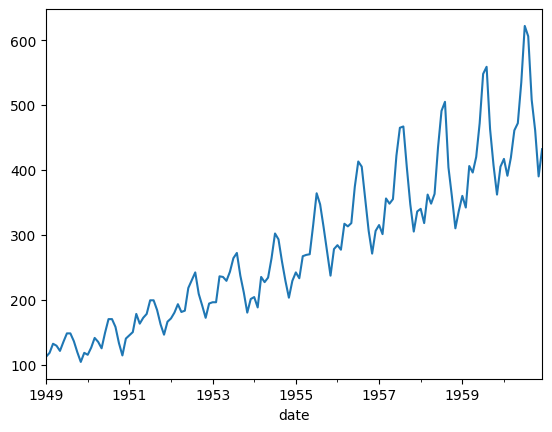

In [71]:
num_passengers.plot()

## Выровняем дисперсию - применим преобразование Бокса-Кокса

In [72]:
from scipy.stats import boxcox

In [73]:
boxed_coxed_passengers, lambda_ = boxcox(num_passengers)

In [74]:
df_boxcox = pd.DataFrame(boxed_coxed_passengers, index=passengers.index)
df_boxcox.columns = ['num_passengers']

In [75]:
df_boxcox

,num_passengers
date,
1949-01-01,6.827490
1949-02-01,6.932822
1949-03-01,7.161892
1949-04-01,7.114611
1949-05-01,6.983787
...,...
1960-08-01,10.684049
1960-09-01,10.234573
1960-10-01,9.992159


<AxesSubplot: xlabel='date'>

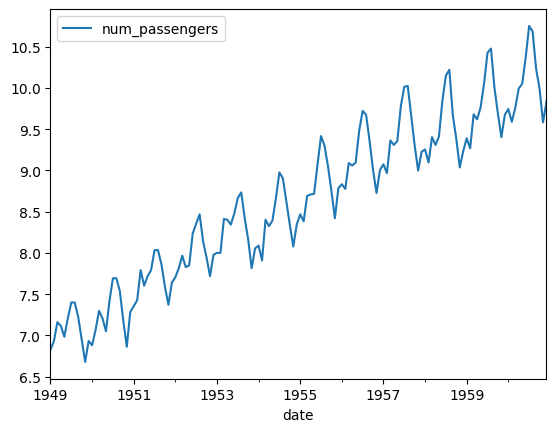

In [76]:
df_boxcox.plot()

Проверим стационарность ряда с помощью критерия Дики Фуллера

In [77]:
from statsmodels.tsa.stattools import adfuller

In [78]:
adfuller(df_boxcox['num_passengers'])

(-1.3260708968567587,
 0.6171620657003666,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -237.2219658853702)

p-value = 0.6 > 0.05 - не стационарен

## Применим сезонное дифференцирование

In [79]:
diff_df_boxcox = df_boxcox['num_passengers'].diff(12).dropna()

In [80]:
diff_df_boxcox

date
1950-01-01    0.053251
1950-02-01    0.133562
1950-03-01    0.136547
1950-04-01    0.093655
1950-05-01    0.066304
                ...   
1960-08-01    0.207164
1960-09-01    0.231678
1960-10-01    0.306024
1960-11-01    0.179190
1960-12-01    0.157709
Name: num_passengers, Length: 132, dtype: float64

<AxesSubplot: xlabel='date'>

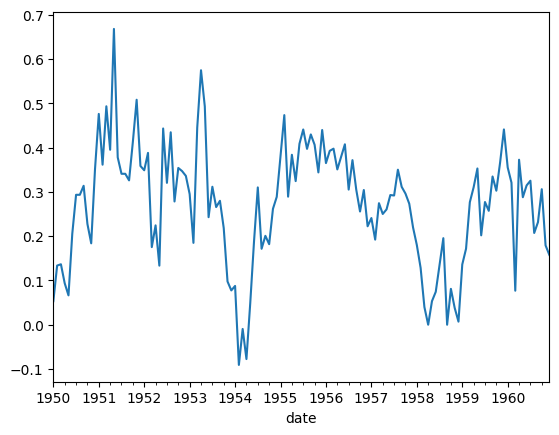

In [81]:
diff_df_boxcox.plot()

Проверим стационарность ряда с помощью критерия Дики Фуллера

In [82]:
adfuller(diff_df_boxcox.values)

(-2.8421134584100365,
 0.05250539863856043,
 12,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 -233.14504941894444)

p-value = 0.052 > 0.05 - не стационарен

## Применим обычное дифференцирование

In [83]:
d_diff_df_boxcox = diff_df_boxcox.diff().dropna()

In [84]:
d_diff_df_boxcox

date
1950-02-01    0.080310
1950-03-01    0.002985
1950-04-01   -0.042892
1950-05-01   -0.027351
1950-06-01    0.139146
                ...   
1960-08-01   -0.118024
1960-09-01    0.024514
1960-10-01    0.074345
1960-11-01   -0.126833
1960-12-01   -0.021481
Name: num_passengers, Length: 131, dtype: float64

In [85]:
d_diff_df_boxcox

date
1950-02-01    0.080310
1950-03-01    0.002985
1950-04-01   -0.042892
1950-05-01   -0.027351
1950-06-01    0.139146
                ...   
1960-08-01   -0.118024
1960-09-01    0.024514
1960-10-01    0.074345
1960-11-01   -0.126833
1960-12-01   -0.021481
Name: num_passengers, Length: 131, dtype: float64

<AxesSubplot: xlabel='date'>

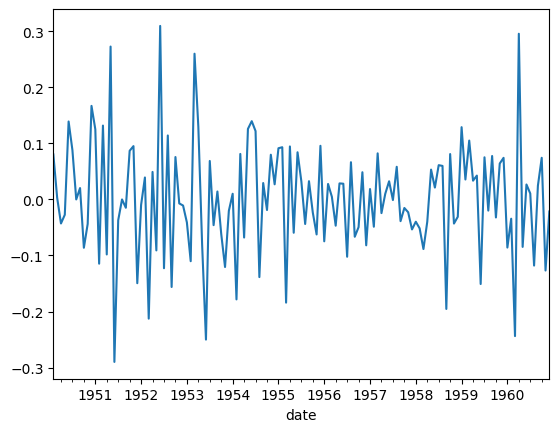

In [86]:
d_diff_df_boxcox.plot()

Проверим стационарность ряда с помощью критерия Дики Фуллера

In [87]:
adfuller(d_diff_df_boxcox.values)

(-4.393872588707451,
 0.00030433262632179004,
 12,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 -224.32535143445227)

p-value = 0.0003 < 0.05 - стационарен

## Теперь можем построить модель SARIMA, строим SARIMA(3, 1, 1)x(1, 1, 0)

### Посчитаем MSE и подберем оптимальные пар-ры с помощью МНК для AR(3, 1)

In [88]:
data = pd.DataFrame(d_diff_df_boxcox)
data.columns = ['y']

In [89]:
data['y(t-12)'] = data['y'].shift(12)
data['y(t-1)'] = data['y'].shift(1)
data['y(t-2)'] = data['y'].shift(2)
data['y(t-3)'] = data['y'].shift(3)

In [90]:
data = data.dropna()
data

,y,y(t-12),y(t-1),y(t-2),y(t-3)
date,,,,,
1951-02-01,-0.114645,0.080310,0.125195,0.166995,-0.043694
1951-03-01,0.131857,0.002985,-0.114645,0.125195,0.166995
1951-04-01,-0.098163,-0.042892,0.131857,-0.114645,0.125195
1951-05-01,0.272862,-0.027351,-0.098163,0.131857,-0.114645
1951-06-01,-0.289975,0.139146,0.272862,-0.098163,0.131857
...,...,...,...,...,...
1960-08-01,-0.118024,-0.019876,0.010598,0.026706,-0.084687
1960-09-01,0.024514,0.077554,-0.118024,0.010598,0.026706
1960-10-01,0.074345,-0.032159,0.024514,-0.118024,0.010598


In [91]:
def my_mse(cur_df, phi12, phi1, phi2, phi3, alpha1):
    n = cur_df.shape[0]
    res = 0
    for i in range(n):
        res += (phi12*cur_df['y(t-12)'].values[i]+phi1*cur_df['y(t-1)'].values[i]+phi2*cur_df['y(t-2)'].values[i]+phi3*cur_df['y(t-3)'].values[i]+alpha1-cur_df['y'].values[i])**2
    return res/n

In [92]:
def get_optimal_params(df):
    return minimize(lambda x: my_mse(df, x[0], x[1], x[2], x[3], x[4]), (0, 0, 0, 0, 0))

In [93]:
get_optimal_params(data)
params = get_optimal_params(data).x

In [94]:
def my_forecast_values(cur_df, phi12, phi1, phi2, phi3, alpha1): # для удобства получения массива полученных аппроксимационных значений
    n = cur_df.shape[0]
    y_forc = []
    for i in range(n):
        y_forc.append(phi12*cur_df['y(t-12)'].values[i]+phi1*cur_df['y(t-1)'].values[i]+phi2*cur_df['y(t-2)'].values[i]+phi3*cur_df['y(t-3)'].values[i]+alpha1)
    return y_forc

In [95]:
forecast = my_forecast_values(data, *params)
df_forecast = pd.DataFrame(forecast)
df_forecast.index = data.index
df_forecast.columns = ['y']

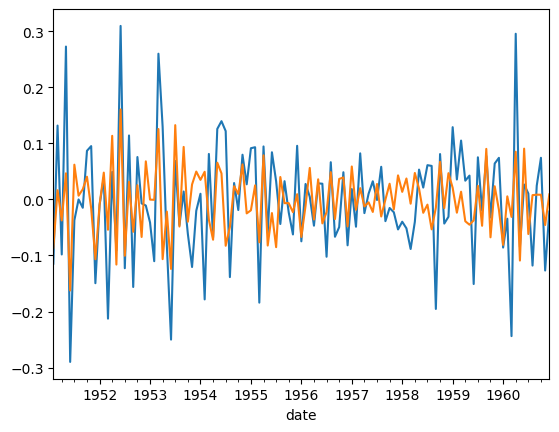

In [96]:
data['y'].plot()
df_forecast['y'].plot()
plt.show()

### Теперь посчитаем MSE и подберем оптимальные пар-ры для MA(1, 0)

In [97]:
def my_real_residuals(y, y_forc): # для удобства получения реальных значений остатков
    n = len(y)
    residuals = []
    for i in range(n):
        residuals.append(y[i]-y_forc[i])
    return residuals

In [98]:
residuals = my_real_residuals(data['y'].values, forecast)

In [99]:
def my_mse_residuals(residuals, theta1, alpha2):
    n = len(residuals)
    res = 0
    res += residuals[0]
    for i in range(1, n):
        res += (theta1*residuals[i-1]+alpha2-residuals[i])**2
    return res/n

In [100]:
def get_optimal_params_residuals(residuals):
    return minimize(lambda x: my_mse_residuals(residuals, x[0], x[1]), (0, 0))

In [101]:
get_optimal_params_residuals(residuals)
params_r = get_optimal_params_residuals(residuals).x

In [102]:
def my_residual_forecast_values(residuals, theta1, alpha2):
    n = len(residuals)
    e_forc = [residuals[0]]
    for i in range(1, n):
        e_forc.append(theta1*residuals[i-1]+alpha2)
    return e_forc

In [103]:
residuals_forc = my_residual_forecast_values(residuals, *params_r)

### В итоге можно построить модель SARIMA(3, 1, 1)x(1, 1, 0), соединив полученные данные

In [104]:
def get_model(forecast, residuals_forc, phi12, phi1, phi2, phi3, alpha1, theta1, alpha2):
    n = len(residuals_forc)
    res = []
    for i in range(n):
        res.append(forecast[i]+residuals_forc[i])
    return res

In [105]:
itog = get_model(forecast, residuals_forc, *params, *params_r)

In [106]:
df_itog = pd.DataFrame(itog)
df_itog.columns = ['y']
df_itog.index = data.index

Итоговый график

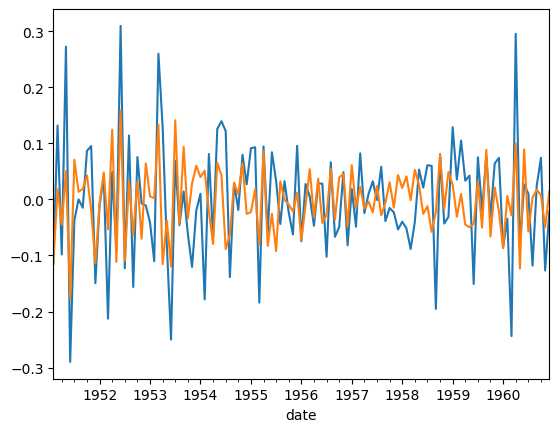

In [107]:
data['y'].plot()
df_itog['y'].plot()
plt.show()

Итоговая ошибка

In [108]:
def my_mse_itog(y, y_aprx):
    n = len(y)
    res = 0
    for i in range(n):
        res += (y[i]-y_aprx[i])**2
    return res/n

In [109]:
my_mse_itog(data['y'].values, itog)

0.007350133934839288

## Построим прогноз

In [110]:
new_data = pd.DataFrame(data['y'].tail(12))

In [122]:
def get_forecast(cur_df, residuals, phi12, phi1, phi2, phi3, alpha1, theta1, alpha2):
    n = cur_df.shape[0]
    residuals = residuals[:-12]
    res = []
    old_idx=cur_df.index
    idx = pd.date_range('1961-01-01', '1963-12-01', freq='MS')
    for i in range(36):
        cur_df = pd.concat([cur_df, pd.DataFrame({'y': phi12*cur_df['y'].values[i]+phi1*cur_df['y'].values[-1]+phi2*cur_df['y'].values[-2]+phi3*cur_df['y'].values[-3]+alpha1+theta1*residuals[i-1]+alpha2}, index=[idx[i]])])
    return cur_df[12::]

In [129]:
residuals[-12:-]

[-0.004738719303817654,
 -0.039883820242832574,
 -0.21277088769527472,
 0.21050906995332513,
 0.024369748101563407,
 -0.06398151086072887,
 0.07231250743168693,
 -0.12573330027890084,
 0.01601040086145518,
 0.06595395965427725,
 -0.08121542862515505]

In [123]:
my_forecast_sarima = get_forecast(new_data, residuals, *params, *params_r)

TypeError: list indices must be integers or slices, not str

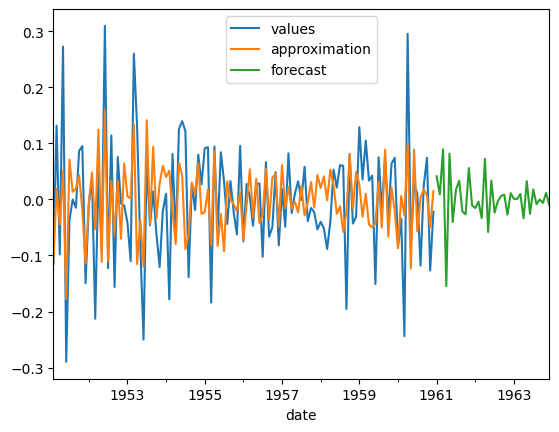

In [113]:
data['y'].rename('values').plot(legend=True)
df_itog['y'].rename('approximation').plot(legend=True)
my_forecast_sarima['y'].rename('forecast').plot(legend=True)
plt.show()

## Преобразуем ряд к исходному виду

Исходный ряд с преобразованием Бокса-Кокса, сезонным и обычным дифференцированием

In [114]:
data = pd.DataFrame(pd.concat([d_diff_df_boxcox, my_forecast_sarima['y']]), columns=['y'])

In [115]:
data

,y
1950-02-01,0.080310
1950-03-01,0.002985
1950-04-01,-0.042892
1950-05-01,-0.027351
1950-06-01,0.139146
...,...
1963-08-01,-0.008437
1963-09-01,-0.000046
1963-10-01,-0.006215
1963-11-01,0.011754


<AxesSubplot: >

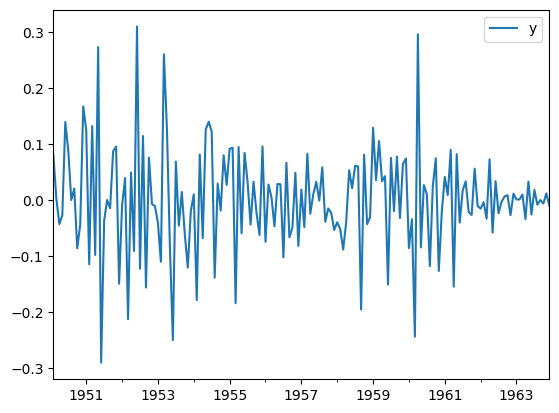

In [116]:
data.plot()

Сначала применим обычное интегрирование, взяв из ряда без дифференцирования первую компоненту, т.к. о ней утеряна информация в полученном ряду

In [55]:
integr_data = pd.DataFrame(np.insert(data['y'].values, 0, values=[diff_df_boxcox.values[0]], axis=0))
integr_data.index = pd.date_range('1950-01-01','1963-12-01', freq='MS')
integr_data.columns = ['y']

In [56]:
for i in range(1, len(integr_data)):
    integr_data['y'][i] = integr_data['y'][i-1] + integr_data['y'][i]

In [57]:
integr_data

,y
1950-01-01,0.053251
1950-02-01,0.133562
1950-03-01,0.136547
1950-04-01,0.093655
1950-05-01,0.066304
...,...
1963-08-01,0.193483
1963-09-01,0.193440
1963-10-01,0.187225
1963-11-01,0.198977


<AxesSubplot: >

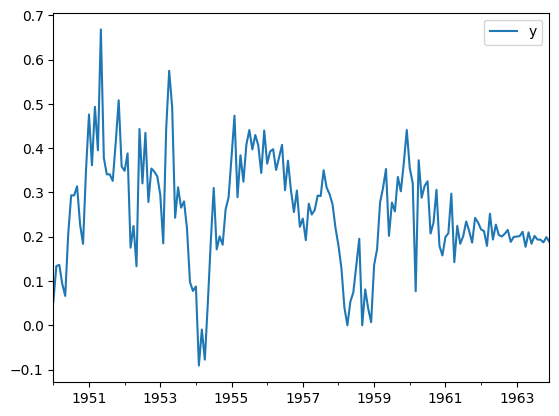

In [58]:
integr_data.plot()

Далее применим сезонное интегрирование, взяв из ряда без сезонного дифференцирования первые 12 значений, т.к. о них тоже была утеряна информация

In [59]:
sintegr_integr_data = pd.DataFrame(np.insert(integr_data['y'].values, 0, values=df_boxcox['num_passengers'].values[:12], axis=0))
sintegr_integr_data.index = pd.date_range('1949-01-01','1963-12-01', freq='MS')
sintegr_integr_data.columns = ['y']

In [60]:
sintegr_integr_data

,y
1949-01-01,6.827490
1949-02-01,6.932822
1949-03-01,7.161892
1949-04-01,7.114611
1949-05-01,6.983787
...,...
1963-08-01,0.193483
1963-09-01,0.193440
1963-10-01,0.187225
1963-11-01,0.198977


In [61]:
for i in range(12, len(sintegr_integr_data)):
    sintegr_integr_data['y'][i] = sintegr_integr_data['y'][i] + sintegr_integr_data['y'][i-12]

In [62]:
sintegr_integr_data

,y
1949-01-01,6.827490
1949-02-01,6.932822
1949-03-01,7.161892
1949-04-01,7.114611
1949-05-01,6.983787
...,...
1963-08-01,11.312599
1963-09-01,10.847963
1963-10-01,10.581199
1963-11-01,10.212392


<AxesSubplot: >

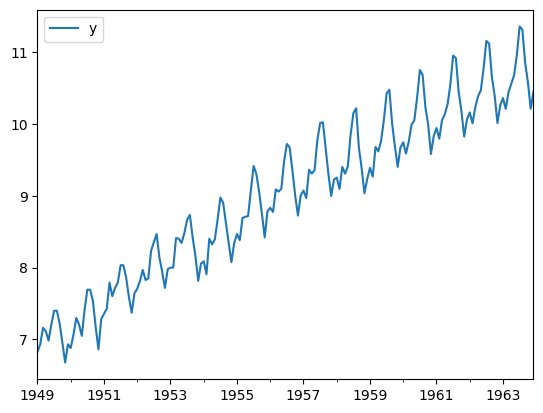

In [63]:
sintegr_integr_data.plot()

И, наконец, применим обратное преобразование Бокса-Кокса

In [64]:
for i in range(len(sintegr_integr_data)):
    sintegr_integr_data['y'][i] = (lambda_*sintegr_integr_data['y'][i] + 1)**(1/lambda_)

In [65]:
sintegr_integr_data

,y
1949-01-01,112.000000
1949-02-01,118.000000
1949-03-01,132.000000
1949-04-01,129.000000
1949-05-01,121.000000
...,...
1963-08-01,769.760281
1963-09-01,645.535077
1963-10-01,582.262051
1963-11-01,503.536334


<AxesSubplot: >

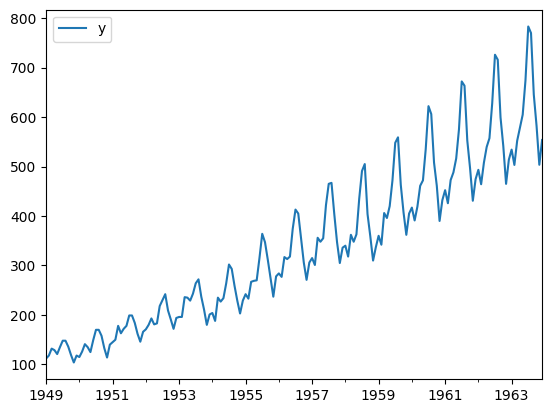

In [66]:
sintegr_integr_data.plot()

В конце концов получили исходный ряд